In [94]:
# No differentiating means it's slow to adjust to new trends (HI has very poor performance for example)
# Differentiating means it does things like go down... Overcompensates for things like Mass

import pandas as pd
import numpy as np
from timeit import default_timer as timer
pd.options.plotting.backend = 'plotly'

In [95]:
train = pd.read_csv('train.csv')
states = train['Province_State'].unique()
state_dfs_raw = {state: train[train['Province_State'] == state] for state in states}
state_means = {}
state_stds = {}
state_dfs = {}
for s, state_df_raw in state_dfs_raw.items():
    state_df = state_df_raw.drop(columns=['Province_State', 'ID'])
    state_df['Date'] = pd.to_datetime(state_df['Date'], format='%m-%d-%Y')
    state_df = state_df.set_index('Date')

    mean, std = state_df.mean(), state_df.std()
    state_df = (state_df - mean) / std

    state_means[s] = mean
    state_stds[s] = std
    state_dfs[s] = state_df

column_names = state_dfs['Alabama'].columns

In [96]:
from fbprophet import Prophet
# univariate prophet

def model_factory():
    return Prophet()

In [117]:
# Normally takes 80s to train
from sklearn.metrics import mean_squared_error as MSE
models = {}
model_histories = {}
model_test_data = {}
for state in states:
    stime = timer()
    print(f'------------------------\nTraining model for {state}')
    data = pd.DataFrame()
    data['y'] = state_dfs[state]['Confirmed'].diff()
    data['ds'] = state_dfs[state].index

    split = int(data.shape[0] * 0.8)
    train = data.iloc[:split]
    test = data.iloc[split:]

    model = model_factory()
    model.fit(train)

    fc = model.predict(test)
    print(f'\tValidation loss for {state}: {np.average(MSE(test["y"], fc["yhat"])):.4f}\n')
    models[state] = model

    print(f'\tTraining took {timer() - stime:.4f}s')


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
------------------------
Training model for Alabama
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
	Validation loss for Alabama: 0.0010

	Training took 1.3807s
------------------------
Training model for Alaska
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
	Validation loss for Alaska: 0.0026

	Training took 1.3584s
------------------------
Training model for Arizona
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
IN

In [118]:
state_forecasts = {}
periods = 26
index = pd.date_range(state_dfs['Alabama'].index[-1], periods=periods + 1)[1:]
for state in states:
    print(f'Forecasting {state}...')
    future = pd.DataFrame()
    future['ds'] = index
    fc = models[state].predict(future)
    fc['Confirmed'] = fc['yhat']
    fc['Deaths'] = 0

    fc = fc.set_index('ds')

    state_forecasts[state] = fc

Forecasting Alabama...
Forecasting Alaska...
Forecasting Arizona...
Forecasting Arkansas...
Forecasting California...
Forecasting Colorado...
Forecasting Connecticut...
Forecasting Delaware...
Forecasting Florida...
Forecasting Georgia...
Forecasting Hawaii...
Forecasting Idaho...
Forecasting Illinois...
Forecasting Indiana...
Forecasting Iowa...
Forecasting Kansas...
Forecasting Kentucky...
Forecasting Louisiana...
Forecasting Maine...
Forecasting Maryland...
Forecasting Massachusetts...
Forecasting Michigan...
Forecasting Minnesota...
Forecasting Mississippi...
Forecasting Missouri...
Forecasting Montana...
Forecasting Nebraska...
Forecasting Nevada...
Forecasting New Hampshire...
Forecasting New Jersey...
Forecasting New Mexico...
Forecasting New York...
Forecasting North Carolina...
Forecasting North Dakota...
Forecasting Ohio...
Forecasting Oklahoma...
Forecasting Oregon...
Forecasting Pennsylvania...
Forecasting Rhode Island...
Forecasting South Carolina...
Forecasting South Dako

In [122]:
cleaned_dfs = {}
for state in states:
    cleaned_df = state_forecasts[state][['Confirmed', 'Deaths']]
    cleaned_df['Province_State'] = state
    cleaned_df['Date'] = cleaned_df.index

    cleaned_df['Confirmed'] = state_dfs[state]['Confirmed'].iloc[-1] + cleaned_df['Confirmed'].cumsum()
    cleaned_df['Confirmed'] *= state_stds[state]['Confirmed']
    cleaned_df['Deaths'] *= state_stds[state]['Deaths']
    cleaned_df['Confirmed'] += state_means[state]['Confirmed']
    cleaned_df['Deaths'] += state_means[state]['Deaths']


    cleaned_dfs[state] = cleaned_df[['Province_State', 'Date', 'Confirmed', 'Deaths']]

kaggle_res = []

for _ in range(periods):
    for state in states:
        kaggle_res.append(state_forecasts[state].iloc[_])

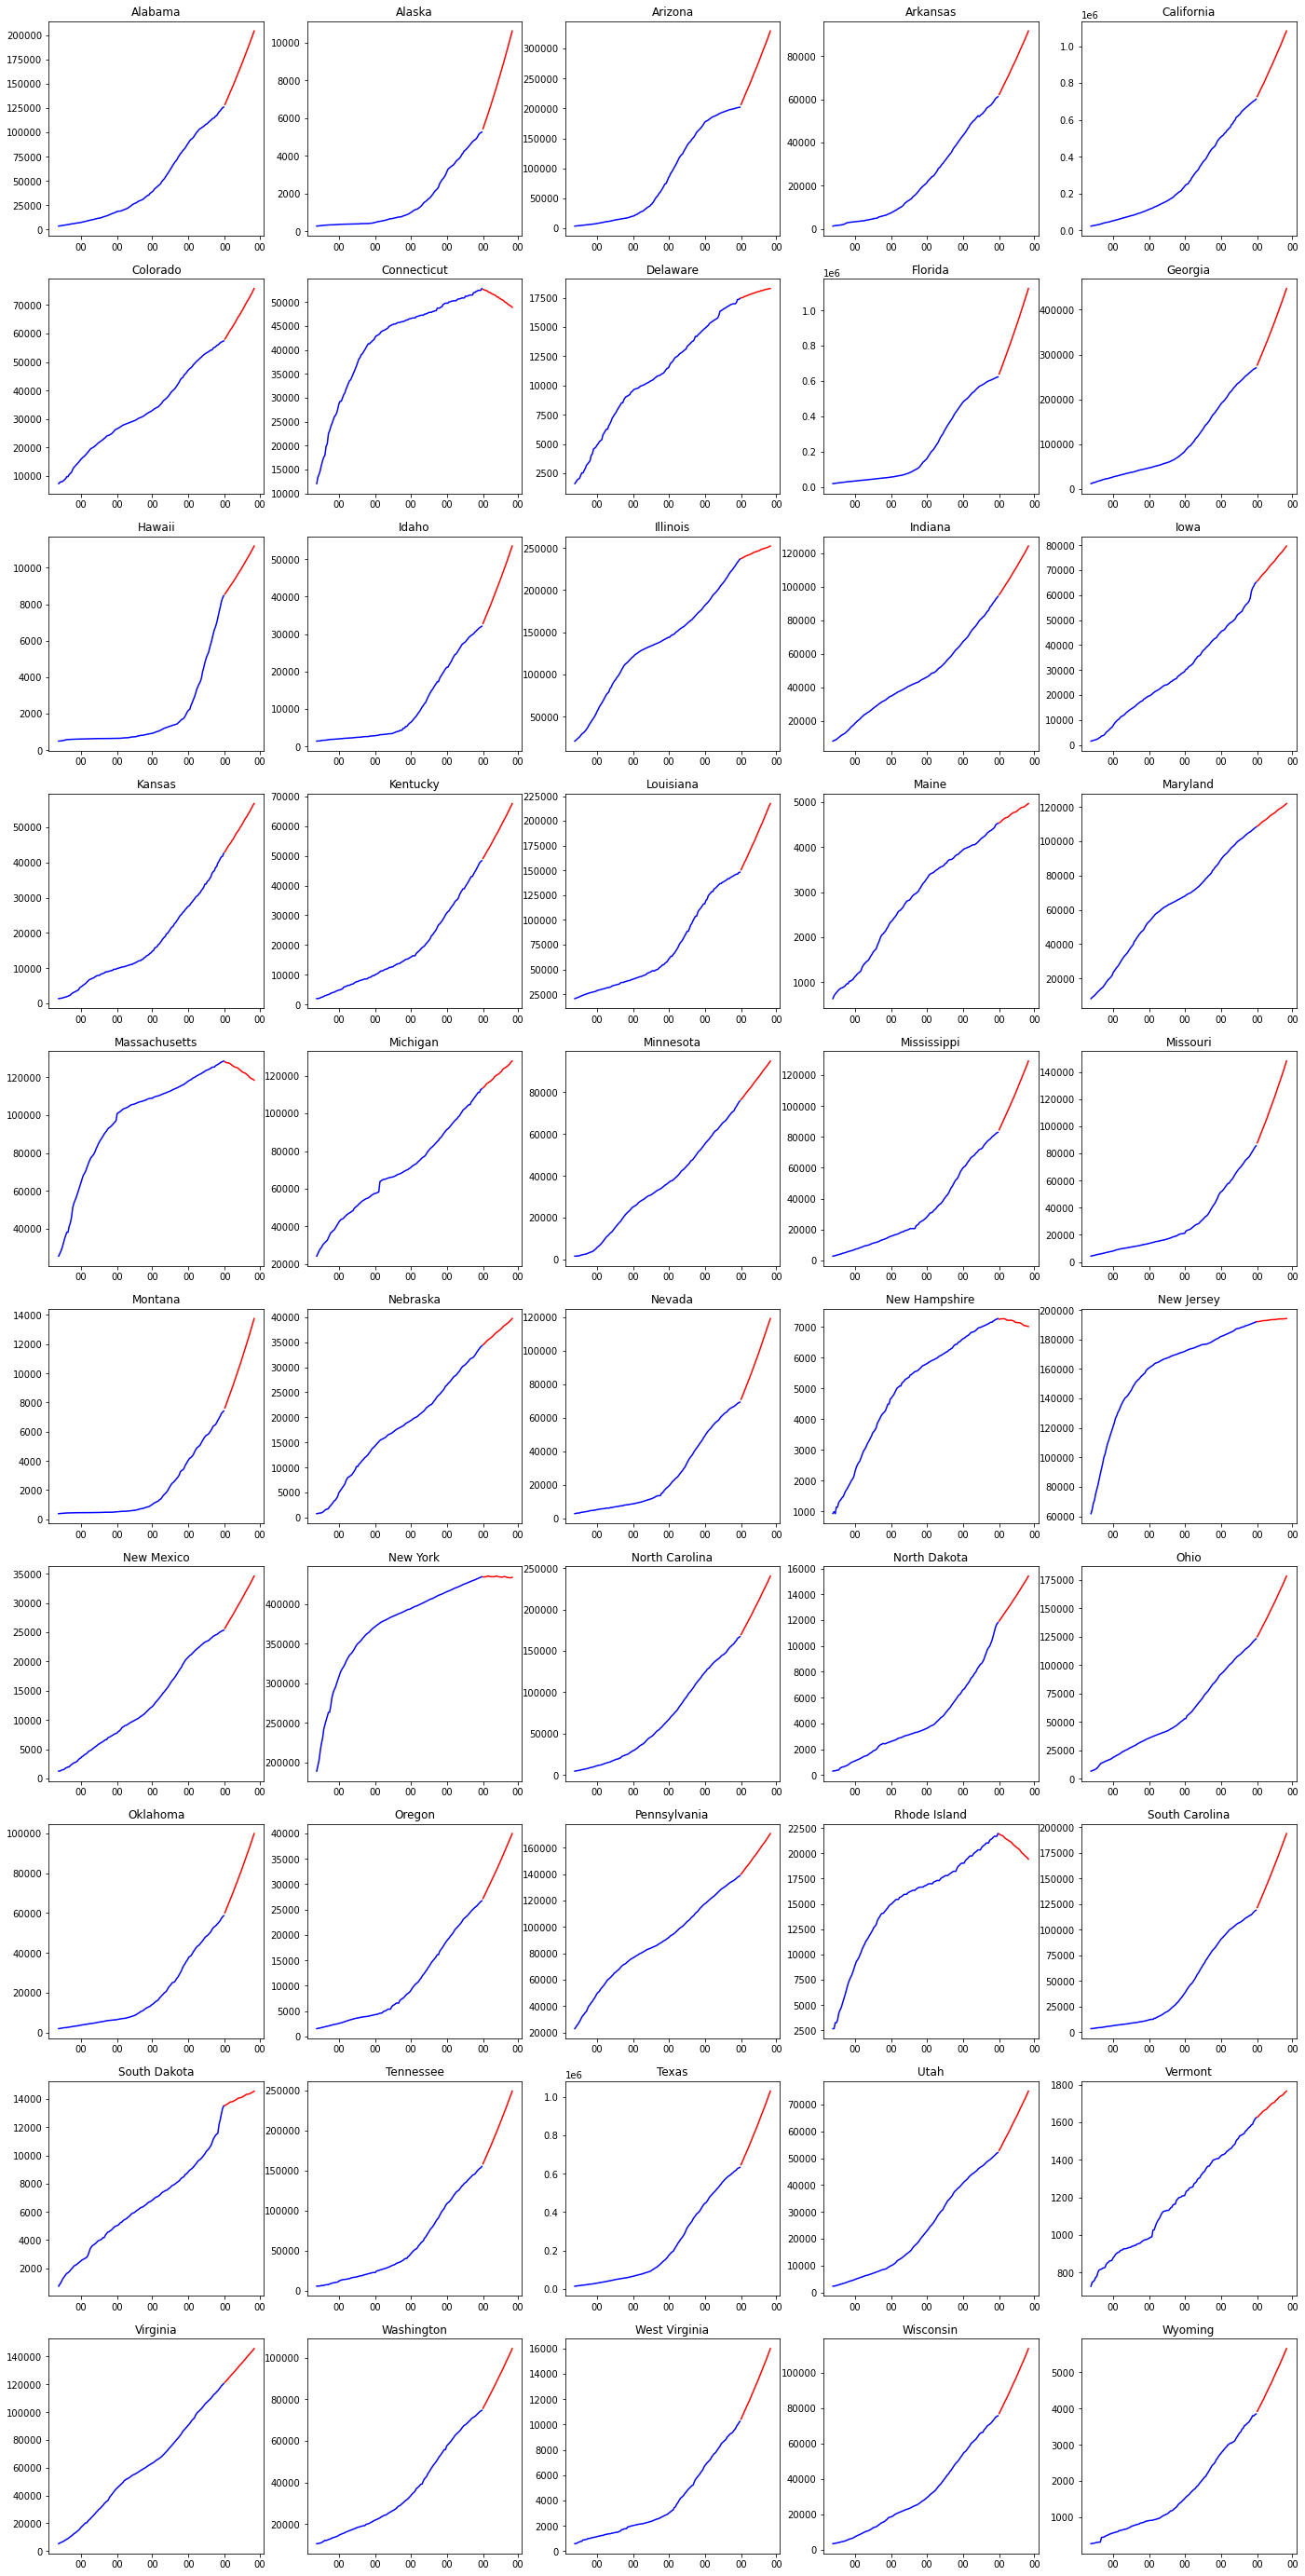

In [126]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (24, 50)

fig, ax = plt.subplots(nrows=10, ncols=5)

i = 0
for row in ax:
    for col in row:
        state = states[i]
        i += 1

        data = state_dfs_raw[state]['Confirmed'].copy()
        data.index = state_dfs[state].index
        fc = cleaned_dfs[state]['Confirmed']
        df = pd.DataFrame()
        df['y'] = data
        df = df.merge(fc, how='outer', left_index=True, right_index=True)

        col.set_title(state)
        col.xaxis.set_major_locator(mpl.dates.MonthLocator())
        col.xaxis.set_major_formatter(mpl.dates.DateFormatter('%M'))
        col.plot(df.index, df['y'], color='blue')
        col.plot(df.index, df['Confirmed'], color='red')

plt.show()

In [28]:
cleaned_dfs['New York']['Confirmed'].plot()

In [21]:
cleaned_dfs['Alabama']['Confirmed'].plot() # state_stds['Alabama']['Confirmed']